In [1]:
! pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d kaustubhb999/tomatoleaf

tomatoleaf.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
from zipfile import ZipFile
dataset='/content/tomatoleaf.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
print("extraction done")

extraction done


In [6]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [7]:
IMAGE_SIZE=128
BATCH_SIZE=4
CHANNELS=3

In [8]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/tomato/train",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 10000 files belonging to 10 classes.


In [9]:
dataset2=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/tomato/val",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1000 files belonging to 10 classes.


In [10]:
class_names=dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [11]:
def get_dataset_partitions_tf(ds,train_split=.8,test_split=.2,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    train_size=int(train_split*ds_size)
    train_ds=ds.take(train_size)
    test_ds=ds.skip(train_size)
    return train_ds,test_ds

In [12]:
train_ds,test_ds=get_dataset_partitions_tf(dataset)
val_ds=dataset2

In [13]:
len(test_ds)

500

In [14]:
len(train_ds)

2000

In [15]:
len(val_ds)

250

In [16]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [18]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(.2),
])

In [19]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10
model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (4, 128, 128, 3)          0         
                                                                 
 conv2d (Conv2D)             (4, 126, 126, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2  (4, 63, 63, 32)           0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (4, 61, 61, 64)           18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (4, 30, 30, 64)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (4, 28, 28, 64)          

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
2000/2000 [==============================] - 32s 11ms/step - loss: 1.8573 - accuracy: 0.3178 - val_loss: 1.3880 - val_accuracy: 0.4930
Epoch 2/15
2000/2000 [==============================] - 21s 11ms/step - loss: 1.2268 - accuracy: 0.5535 - val_loss: 1.1230 - val_accuracy: 0.6070
Epoch 3/15
2000/2000 [==============================] - 27s 14ms/step - loss: 0.8984 - accuracy: 0.6796 - val_loss: 0.7777 - val_accuracy: 0.7190
Epoch 4/15
2000/2000 [==============================] - 22s 11ms/step - loss: 0.7189 - accuracy: 0.7516 - val_loss: 0.7075 - val_accuracy: 0.7350
Epoch 5/15
2000/2000 [==============================] - 22s 11ms/step - loss: 0.6118 - accuracy: 0.7847 - val_loss: 0.5530 - val_accuracy: 0.8010
Epoch 6/15
2000/2000 [==============================] - 20s 10ms/step - loss: 0.5318 - accuracy: 0.8124 - val_loss: 0.6465 - val_accuracy: 0.7730
Epoch 7/15
2000/2000 [==============================] - 21s 11ms/step - loss: 0.4707 - accuracy: 0.8366 - val_loss: 0.7216 -

In [26]:
scores = model.evaluate(test_ds)
scores

500/500 [==============================] - 8s 4ms/step - loss: 0.2671 - accuracy: 0.9075


[0.26712074875831604, 0.9075000286102295]

In [24]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 2000}

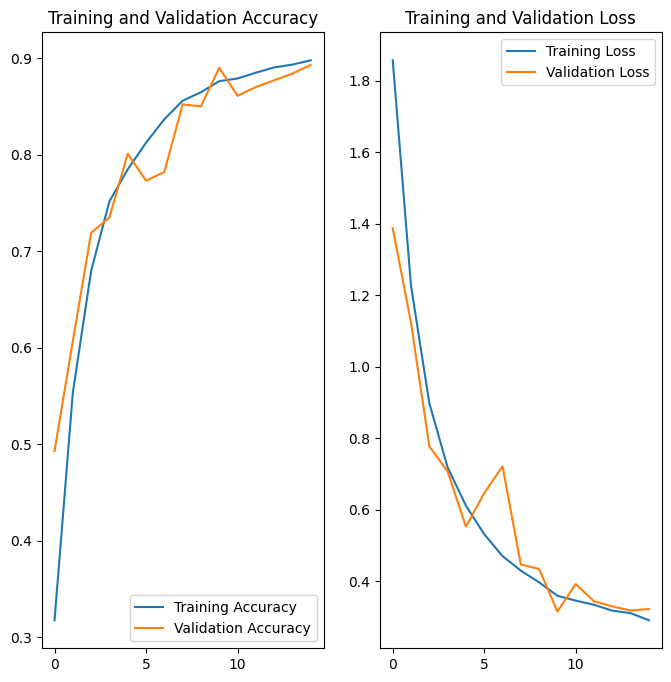

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(15), acc, label='Training Accuracy')
plt.plot(range(15), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(15), loss, label='Training Loss')
plt.plot(range(15), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato___Spider_mites Two-spotted_spider_mite
1/1 [==============================] - 0s 230ms/step
predicted label: Tomato___Spider_mites Two-spotted_spider_mite


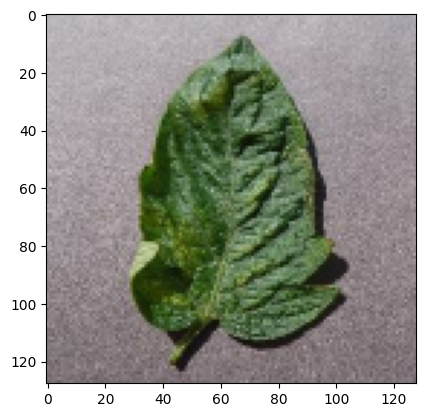

In [27]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


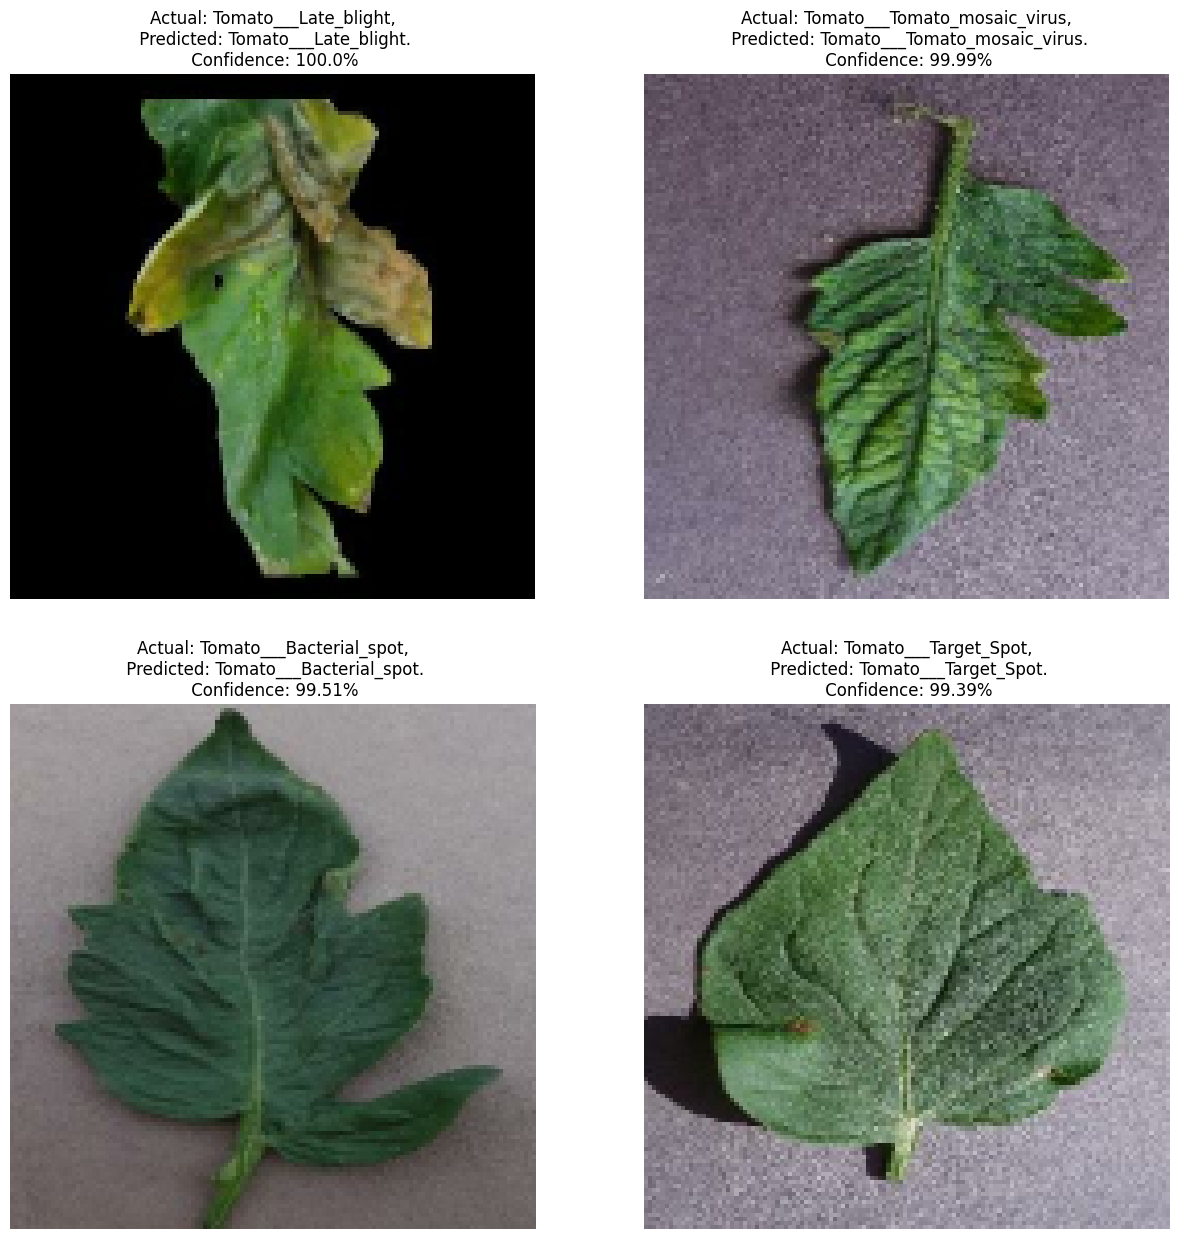

In [29]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2,2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [30]:
import os
model_version=1
model.save(f"./models/{model_version}")

In [31]:
model.save("./tomato_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
